#**Project: Bayesian Neural Network**
*Cojocariu Sebastian - Group 407*

### **Imports**

In [ ]:
!pip install pyro-ppl
!pip install seaborn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.distributions

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import pyro.optim
from pyro.distributions import Normal, Categorical, Bernoulli, constraints
from scipy.interpolate import make_interp_spline, BSpline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_moons, make_classification

import pyro
import pyro.distributions as dist

import warnings
warnings.filterwarnings('ignore')

**Helper to prepare model's output for prediction**

In [ ]:
# Helper to format predictions.
# Predicted is assumed to be PyTorch Tensor
# Based on the parameter sample_from_distribution_for_evaluation, we either extract
# from a distribution (bayesian approach), or predict directly on the value (as in Deep Learning Approach)
# Resulted type: numpy.ndarray
def format_predictions(eval_type, predicted, sample_from_distribution_for_evaluation):
    assert isinstance(predicted, torch.Tensor)

    if eval_type.lower() == "logistic_regression":
        if sample_from_distribution_for_evaluation:
            predicted = Bernoulli(predicted).sample().detach().numpy()
        else:
            predicted = np.asarray([0 if x < 0.5 else 1 for x in predicted])
    elif eval_type.lower() == "classification":
        if sample_from_distribution_for_evaluation:
            predicted = Categorical(predicted).sample().detach().numpy()
        else:
            predicted = torch.argmax(torch.softmax(predicted, dim=-1), dim=-1).detach().numpy()
    elif eval_type.lower() == "regression":
        predicted = predicted.detach().numpy()
    else:
        raise Exception("UNKNOWN eval_type: {}".format(self.eval_type))
    
    return predicted

**Helper to plot loss + scores on train/test + smoothing**

In [ ]:
# Helper to plot scores on test and train while comparing the loss.
# A smoothing technique is applied (BSpline)
def plot_scores(train_losses, scores_train, scores_test, score_name, degree=3, window_length=5):
    assert len(scores_train) == len(scores_test) and len(train_losses) == len(scores_train)

    def moving_average(x):
        return np.convolve(x, np.ones(window_length), 'valid') / window_length
    
    train_losses = moving_average(train_losses)
    scores_train = moving_average(scores_train)
    scores_test = moving_average(scores_test)

    x = np.arange(1, len(scores_train) + 1, dtype=np.uint16)
    xnew = np.linspace(x.min(), x.max(), 150)

    new_train_losses = make_interp_spline(x, train_losses, k=degree)(xnew)
    new_scores_train = make_interp_spline(x, scores_train, k=degree)(xnew)
    new_scores_test = make_interp_spline(x, scores_test, k=degree)(xnew)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    fig.suptitle("Model Performance", fontsize=16)
    for i, ax in enumerate(axs.reshape(-1)):
        if i == 0:
            ax.plot(xnew, new_train_losses, color="black", label="Loss")
            ax.set_title("LOSS during training")
            ax.legend()
        elif i == 1:
            ax.plot(xnew, new_scores_train, color="green", label="{} TRAIN".format(score_name))
            ax.plot(xnew, new_scores_test, color="red", label="{} TEST".format(score_name))
            ax.set_title("{} during training".format(score_name))
            ax.legend()

**Generic Bayesian Neural Network**

In [ ]:
class BayesianNeuralNetwork():
    def __init__(self, neural_model, eval_type):
        super(BayesianNeuralNetwork).__init__()
        # the DL model that will be transformed in a Bayesian model  
        self.neural_model = neural_model
        # eval_type should be either "regression", "logistic_regression" (binary classification)
        # or "classification" (for multi-class classification)
        self.eval_type = eval_type
        # scores + loss that will pe update during training + final evaluation 
        self.loss_train_list = []
        self.score_train_list = []
        self.score_test_list = []
        
        # based on the eval_type, compute the correct test_score_function
        if eval_type.lower() == "regression":
            self.test_score_function = ["MSE", mean_squared_error]
        elif eval_type.lower() in ["logistic_regression", "classification"]:
            self.test_score_function = ["ACCURACY", accuracy_score]
        else:
            raise Exception("UNKNOWN eval_type: {}".format(eval_type))
    
    def model(self, x, y):
        # Set priors to each weight
        # Assume a normal distribution of params: loc, scale
        def set_prior(weights, loc=0., scale=1.):
            loc = torch.full_like(weights, loc)
            scale = torch.full_like(weights, scale)
            return Normal(loc=loc, scale=scale)
        
        # Add to priors every parameters from the DL model that contains bias or weight in their names
        # Assume a normal distribution of mean=0 and std=1 for the priors as per project requirements
        priors = {}
        for name_tensor in self.neural_model.state_dict():
            if "bias" in name_tensor:
                priors[name_tensor] =  set_prior(self.neural_model.state_dict()[name_tensor], loc=0., scale=1.)
            elif "weight" in name_tensor:
                priors[name_tensor] =  set_prior(self.neural_model.state_dict()[name_tensor], loc=0., scale=1.)
        
        # transform the neural model
        lift_neural_model = pyro.random_module("module", self.neural_model, priors)

        # instantiate the model
        nn_model = lift_neural_model()

        # run the model and apply squeeze
        predicted = nn_model(x).squeeze()

        # choose type of task: binary(logistic_regression)/multiclass(softmax)
        # and sample from the corresponding distribution
        if self.eval_type.lower() == "logistic_regression":
            with pyro.plate('data'):
                pyro.sample('obs', Bernoulli(predicted), obs=y)
        elif self.eval_type.lower() == "classification":
            with pyro.plate('data'):
                pyro.sample('obs', Categorical(logits=predicted), obs=y)
        elif self.eval_type.lower() == "regression":
            with pyro.plate('data'):
                pyro.sample('obs', Normal(predicted, torch.full_like(predicted, 0.1)), obs=y)
        else:
            raise Exception("UNKNOWN eval_type: {}".format(self.eval_type))
        
        return predicted
    
    # An own guide implementation  
    def own_guide(self, x, y):
        def register_parameters(weights, name_weights, mean, std):
            # register weights
            mean_weights = pyro.param('mean_{}'.format(name_weights), torch.full_like(weights, mean))
            std_weights = F.softplus(pyro.param('std_{}'.format(name_weights), torch.full_like(weights, std), constraint=constraints.positive))
            prior_weights = Normal(mean_weights, std_weights)
            return prior_weights

        # add to priors every parameters from the DL model that contains bias or weight in their names
        priors = {}
        for name_tensor in self.neural_model.state_dict():
            if "bias" in name_tensor:
                priors[name_tensor] =  register_parameters(self.neural_model.state_dict()[name_tensor], name_weights=name_tensor, mean=0., std=1.)
            elif "weight" in name_tensor:
                priors[name_tensor] =  register_parameters(self.neural_model.state_dict()[name_tensor], name_weights=name_tensor, mean=0., std=1.)
        
        # transform the neural model
        lift_neural_model = pyro.random_module("module", self.neural_model, priors)
        
        # return the new model
        return lift_neural_model()
    
    def train(self, X_train, Y_train, X_test, Y_test, guide, lr, no_epochs, batch_size, sample_from_distribution_for_evaluation, sanity_check=False, plot_hist=False, evaluate=False, frequency=5):
        print("########## STARTED TRAINING ##########\n")

        # Clear parameter store
        pyro.clear_param_store()
        
        # Intantiate the optimizer
        optim = pyro.optim.Adam({"lr": lr})

        # Instantiate the guide
        if guide.lower() in ["adn", "autodiagonalnormal", "normal"]:
            self.guide = AutoDiagonalNormal(self.model)
            self.guide_name = "AutoDiagonalnormal"
        elif guide.lower() in ["lowrank", "autolowrankmultivariatenormal"]:
            self.guide = AutoLowRankMultivariateNormal(self.model)
            self.guide_name = "AutoLowRankMultivariateNormal"
        elif guide.lower() in ["own", "own_guide", "ownguide"]:
            self.guide = self.own_guide
            self.guide_name = "OwnGuide"
        else:
            raise Exception("[train] UNKNOWN guide name: {}".format(guide))
        
        # if batch_size is not a number, let it be the length of the entire dataset
        if type(batch_size) != int and (batch_size is None or batch_size.lower() == "all"):
            batch_size = len(X_train)
        
        svi = SVI(model=self.model, guide=self.guide, optim=optim, loss=Trace_ELBO()) 
        batches_x_train, batches_y_train = torch.split(X_train, batch_size), torch.split(Y_train, batch_size)
        
        assert len(batches_x_train) == len(batches_y_train)
       
        for epoch in range(no_epochs):
            loss_train = 0
            for i in range(len(batches_x_train)):
                loss_train += svi.step(batches_x_train[i], batches_y_train[i])
            loss_train = loss_train / len(X_train)
            
            score_train = self.evaluate(X_train, Y_train, sample_from_distribution_for_evaluation)
            score_test = self.evaluate(X_test, Y_test, sample_from_distribution_for_evaluation)
          
            self.loss_train_list.append(loss_train)
            self.score_train_list.append(score_train)
            self.score_test_list.append(score_test)
            name_score = self.test_score_function[0]

            if epoch % frequency == 0:
                print("[Epoch = {} -> LOSS_train: {}, {}_train: {}, {}_test: {} ".format(epoch, loss_train, name_score, score_train, name_score, score_test))
        print("\n########## END TRAINING ##########\n")
        
        self.loss_train_list = np.asarray(self.loss_train_list)
        self.score_train_list = np.asarray(self.score_train_list)
        self.score_test_list = np.asarray(self.score_test_list)

        # Plot histograms for weights
        if plot_hist:
            self.plotHist(X_train=X_train, 
                          Y_train=Y_train,
                          sanity_check=sanity_check)

        # Evaluate on train and test with the corresponding func_score
        # Accuracy for classification and MSE for regression 
        if evaluate:
            score_train = self.evaluate(X_train, Y_train, sample_from_distribution_for_evaluation)
            score_test = self.evaluate(X_test, Y_test, sample_from_distribution_for_evaluation)
            name_score = self.test_score_function[0]

            print("\n########## {} ON TRAIN = {}\n".format(name_score, score_train))
            print("########## {} ON TEST = {}\n".format(name_score, score_test))

            # Plot func_score + losses
            plot_scores(train_losses=self.loss_train_list,
                        scores_train=self.score_train_list,
                        scores_test=self.score_test_list,
                        score_name=name_score)
    
    def evaluate(self, X, Y, sample_from_distribution_for_evaluation):
        self.guide.requires_grad_(False)
        
        # run on 250 samples extracted from the weights distributions trained so far
        predictions = Predictive(model=self.model, guide=self.guide, num_samples=250, return_sites=["_RETURN"])(X, Y)["_RETURN"]

        # combine the predictions based on the task (mean for regression and majority vote for classification)
        predictions = self.majority_vote(eval_type=self.eval_type, 
                                         predictions_list=predictions, 
                                         sample_from_distribution_for_evaluation=sample_from_distribution_for_evaluation)
        
        # compute the final score
        score = self.test_score_function[1](Y.detach().numpy(), predictions)
        
        self.guide.requires_grad_(True)
        
        # return score
        return score
    
    # method that combines the predictions of multiple bayesian networks based on the task at hand
    # (mean for regression and majority vote for classification)
    def majority_vote(self, eval_type, predictions_list, sample_from_distribution_for_evaluation):
        predictions = []
        # convert each prediction to the corresponding format (to be used later by the majority algorithm) 
        for i in range(len(predictions_list)):
            predictions.append(format_predictions(eval_type=eval_type, 
                                                  predicted=predictions_list[i], 
                                                  sample_from_distribution_for_evaluation=sample_from_distribution_for_evaluation))
      
        predictions = torch.tensor(predictions)
        
        # Classification case
        if eval_type.lower() in ["logistic_regression", "classification"]:
            majority = []
            for j in range(len(predictions[0])):
                # classes frequency dictionary
                class_dictionary = {}
                for i in range(len(predictions)):
                    class_dictionary[predictions[i][j]] = class_dictionary.get(predictions[i][j], 0) + 1
                maximum, maxjority_class = float("-Infinity"), None
                for key in class_dictionary:
                    if maximum < class_dictionary[key]:
                        maximum = class_dictionary[key]
                        majority_class = key
                # add majority class
                majority.append(majority_class)
            majority = np.asarray(majority, dtype=np.uint8) 
        # Regression Case
        elif eval_type.lower() == "regression":
            majority = torch.mean(predictions, 0, False).detach().numpy()
        else:
            raise Exception("UNKNOWN eval_type: {}".format(self.eval_type))
      
        return majority
  
    # method that load an NN after training based on own guide implementation
    def loadNN(self):
        final_neural_model = copy.deepcopy(self.neural_model)
        
        dict_tensors = final_neural_model.state_dict()
        for name in dict_tensors:
            if 'mean_{}'.format(name) in pyro.get_param_store():
                dict_tensors[name] = self.get_weights('mean_{}'.format(name))

        final_neural_model.load_state_dict(dict_tensors)
        
        return final_neural_model

    # helper to plot weights distributions 
    def plotHist(self, X_train, Y_train, verbose=False, sanity_check=False, plot_distributions=False):
        self.guide.requires_grad_(False)
        
        predictive = Predictive(self.model, guide=self.guide, num_samples=1000)

        svi_samples = {k: v.detach().numpy() for k, v in predictive(X_train, Y_train).items() if k != "obs"}
        no_params = len(svi_samples)
        
        # Plot each weight for sanity check
        if sanity_check:
            for idx, key in enumerate(svi_samples): 
                shape_dim = len(svi_samples[key].shape)
                if shape_dim == 2:
                    fig, axs = plt.subplots(nrows=1, ncols=svi_samples[key].shape[1], figsize=(12, 10), squeeze=False)
                    for j in range(svi_samples[key].shape[1]):
                        aux = svi_samples[key][:, j]
                        sns.distplot(aux, ax=axs[0][j], label="{}_{}".format(key[9:], j))
                        axs[0][j].set_title("{}_{}".format(key[9:], j))
                elif shape_dim == 3:
                    fig, axs = plt.subplots(nrows=svi_samples[key].shape[1], ncols=svi_samples[key].shape[2], figsize=(12, 10), squeeze=False)
                    for i in range(svi_samples[key].shape[1]):
                        for j in range(svi_samples[key].shape[2]):
                            aux = svi_samples[key][:, i, j]
                            sns.distplot(aux, ax=axs[i][j], label="{}_{}".format(key[9:], i * svi_samples[key].shape[1] + j))
                            axs[i][j].set_title("{}_{}".format(key[9:], i * svi_samples[key].shape[1] + j)) 
        
        if plot_distributions:
            # Plot summary of each weight distributions
            fig, axs = plt.subplots(nrows=math.ceil(math.sqrt(no_params)), ncols=math.ceil(math.sqrt(no_params)), figsize=(12, 10))
            fig.suptitle("Marginal Posterior density", fontsize=16)
            for i, (ax, key) in enumerate(zip(axs.reshape(-1), svi_samples)):
                sns.distplot(svi_samples[key], ax=ax, label="SVI {}".format(self.guide_name))
                ax.set_title(key[9:])

        # print a summary of weights distributions
        if verbose:
            print("########## PLOT HISTOGRAMS ##########\n")
            for name in self.neural_model.state_dict():
                if 'mean_{}'.format(name) in pyro.get_param_store() and 'std_{}'.format(name) in pyro.get_param_store():
                    mean = self.get_weights('mean_{}'.format(name)).detach().numpy()
                    std = self.get_weights('std_{}'.format(name)).detach().numpy()
                    print("### {} ###\nmean:\n  {}\nstd:\n  {}\n\n".format(name, mean, std))
            print("########## END PLOT HISTOGRAMS ##########\n")
        self.guide.requires_grad_(True)
        
    def get_weights(self, name):
        return pyro.get_param_store()[name]

Loop to train deep learning models

In [ ]:
# method that trains a model using X_train, Y_train, X_test, Y_test
# based on eval_type ("regression" or ["logistic_regression","classification"]) it trains 
# and test the model received as parameter.
# it chooses automatically it's criterion based on the task at hand
def train_deep_learning(model, X_train, Y_train, X_test, Y_test, eval_type, lr=0.001, epochs=100, batch_size=16, frequency=5):
     # get the test_score_function corresponding to eval_type (regression vs binary/multiclass classification)
    if eval_type.lower() in ["logistic_regression", "classification"]:
        test_score_function = accuracy_score
        name_score_function = "ACCURACY"
        if eval_type.lower() == "logistic_regression":
            criterion = torch.nn.BCEWithLogitsLoss()
        else:
            criterion = torch.nn.CrossEntropyLoss()
    elif eval_type.lower() == "regression":
        test_score_function = mean_squared_error
        name_score_function = "MSE"
        criterion = torch.nn.MSELoss()
    
    if type(batch_size) != int:
        batch_size = len(X_train)

    # helper to predict without training the model (testing purposes)
    def predict(batches, Y):
        with torch.no_grad():
            predictions = []
            for batch in batches:
                predicted = model(batch)
                predicted = format_predictions(eval_type=eval_type, predicted=predicted, sample_from_distribution_for_evaluation=False)
                for pred in predicted:
                    predictions.append(pred)
            return test_score_function(Y.detach().numpy(), predictions)

    print("########## STARTED TRAINING ##########\n")
    
    # instatiate an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # split dataset into batches
    batches_x_train, batches_y_train = torch.split(X_train, batch_size), torch.split(Y_train, batch_size)
    batches_x_test, batches_y_test = torch.split(X_test, batch_size), torch.split(Y_test, batch_size)

    assert len(batches_x_train) == len(batches_y_train)
    assert len(batches_x_test) == len(batches_y_test)
    
    # start training loop
    loss_train_list, score_train_list, score_test_list = [], [], []
    for epoch in range(epochs):
        # train for each batch in batches
        total_loss = 0.
        for i in range(len(batches_x_train)):
            optimizer.zero_grad() 
            output = model(batches_x_train[i])
            loss = criterion(output, batches_y_train[i])
            total_loss += loss
            loss.backward()
            optimizer.step()
        total_loss = total_loss / len(X_train)
        
        # assess performance on train and test
        score_train = predict(batches_x_train, Y_train)
        score_test = predict(batches_x_test, Y_test)

        # append the loss and score on train + test
        loss_train_list.append(total_loss.item())
        score_train_list.append(score_train.item())
        score_test_list.append(score_test.item())
        
        # print some training info 
        if epoch % frequency == 0:
            print("[Epoch = {} -> LOSS_train: {}, {}_train: {}, {}_test: {}".format(epoch, total_loss, name_score_function, score_train, name_score_function, score_test))

    # convert to numpy.ndarray
    loss_train_list = np.asarray(loss_train_list)
    score_train_list = np.asarray(score_train_list)
    score_test_list = np.asarray(score_test_list)

    # plot loss + score on train + test
    plot_scores(train_losses=loss_train_list,
                scores_train=score_train_list,
                scores_test=score_test_list,
                score_name=name_score_function)

    print("########## END TRAINING ##########\n")


### **Sanity Check**

**Prepare the data according with the transformation required in the Sanity Check sections of the project**

In [ ]:
# Apply the same transformations as described in the project (only this time using weight multiplication instead)
def apply_function(X):
  weights1 = np.asarray([[1.0, 1.0],[1.0, 1.0]])
  weights2 = np.asarray([1.0, 1.0])
  Y = np.dot(X, weights1)
  Y = np.tanh(Y)
  Y = np.dot(Y, weights2)
  Y = 1/(1 + np.exp(-Y))
  Y = np.asarray([0 if Y[i] < 0.5 else 1 for i in range(len(Y))])
  return torch.tensor(X, dtype=torch.float), torch.tensor(Y, dtype=torch.float)

X_train_sanity_check = np.random.randn(100,2)
X_test_sanity_check = np.random.randn(100,2)

X_train_sanity_check, Y_train_sanity_check = apply_function(X_train_sanity_check)
X_test_sanity_check, Y_test_sanity_check = apply_function(X_test_sanity_check)

print(X_train_sanity_check.shape, Y_train_sanity_check.shape)
print(X_test_sanity_check.shape, Y_test_sanity_check.shape)

torch.Size([100, 2]) torch.Size([100])
torch.Size([100, 2]) torch.Size([100])


**Simple NN Model for Regression**

In [ ]:
# NN class for the Sanity Check
class NNSanityCheck(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(NNSanityCheck, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        res = self.fc1(x)
        res = torch.tanh(res)
        res = self.fc2(res)
        res = torch.sigmoid(res)
        return torch.squeeze(res)

**Deep Learning Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 0.014127845875918865, ACCURACY_train: 0.54, ACCURACY_test: 0.53
[Epoch = 5 -> LOSS_train: 0.01382477767765522, ACCURACY_train: 0.54, ACCURACY_test: 0.53
[Epoch = 10 -> LOSS_train: 0.01354551874101162, ACCURACY_train: 0.59, ACCURACY_test: 0.59
[Epoch = 15 -> LOSS_train: 0.013287722133100033, ACCURACY_train: 0.64, ACCURACY_test: 0.66
[Epoch = 20 -> LOSS_train: 0.013029823079705238, ACCURACY_train: 0.7, ACCURACY_test: 0.68
[Epoch = 25 -> LOSS_train: 0.012770574539899826, ACCURACY_train: 0.76, ACCURACY_test: 0.78
[Epoch = 30 -> LOSS_train: 0.012520539574325085, ACCURACY_train: 0.81, ACCURACY_test: 0.85
[Epoch = 35 -> LOSS_train: 0.012288885191082954, ACCURACY_train: 0.86, ACCURACY_test: 0.9
[Epoch = 40 -> LOSS_train: 0.01208091713488102, ACCURACY_train: 0.92, ACCURACY_test: 0.93
[Epoch = 45 -> LOSS_train: 0.011900858953595161, ACCURACY_train: 0.93, ACCURACY_test: 0.93
[Epoch = 50 -> LOSS_train: 0.01174927968531847, ACCURACY_

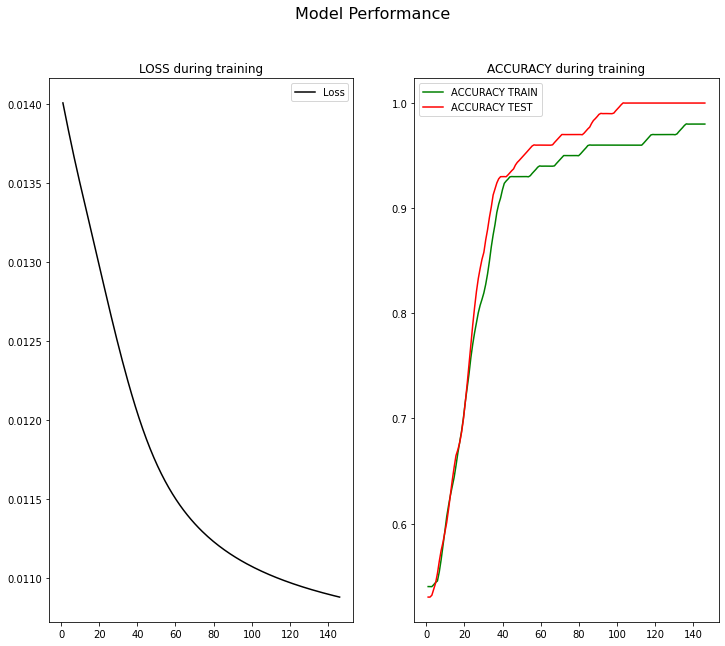

In [ ]:
neural_model_sanity_check = NNSanityCheck(in_features=2,
                             hidden_features=2,
                             out_features=1)


train_deep_learning(neural_model_sanity_check, 
                    X_train_sanity_check, Y_train_sanity_check, X_test_sanity_check, Y_test_sanity_check,
                    eval_type="logistic_regression",
                    lr=0.01,
                    epochs=150,
                    batch_size=64,
                    frequency=5)

**Bayesian Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 0.8066715395450592, ACCURACY_train: 0.67, ACCURACY_test: 0.68 
[Epoch = 5 -> LOSS_train: 0.754003466963768, ACCURACY_train: 0.85, ACCURACY_test: 0.85 
[Epoch = 10 -> LOSS_train: 0.5969983530044556, ACCURACY_train: 0.81, ACCURACY_test: 0.87 
[Epoch = 15 -> LOSS_train: 0.553297376036644, ACCURACY_train: 0.94, ACCURACY_test: 0.95 
[Epoch = 20 -> LOSS_train: 0.43829918146133423, ACCURACY_train: 0.94, ACCURACY_test: 0.91 
[Epoch = 25 -> LOSS_train: 0.34656371295452115, ACCURACY_train: 0.96, ACCURACY_test: 0.91 
[Epoch = 30 -> LOSS_train: 0.37292061030864715, ACCURACY_train: 0.95, ACCURACY_test: 0.88 
[Epoch = 35 -> LOSS_train: 0.31185812830924986, ACCURACY_train: 0.95, ACCURACY_test: 0.98 
[Epoch = 40 -> LOSS_train: 0.2804872316122055, ACCURACY_train: 1.0, ACCURACY_test: 0.92 
[Epoch = 45 -> LOSS_train: 0.2820060747861862, ACCURACY_train: 0.97, ACCURACY_test: 0.98 

########## END TRAINING ##########


########## ACCURACY ON 

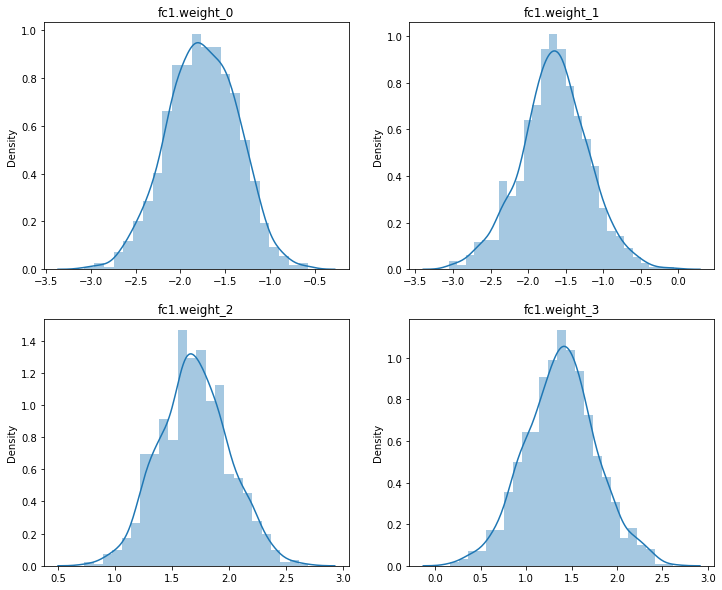

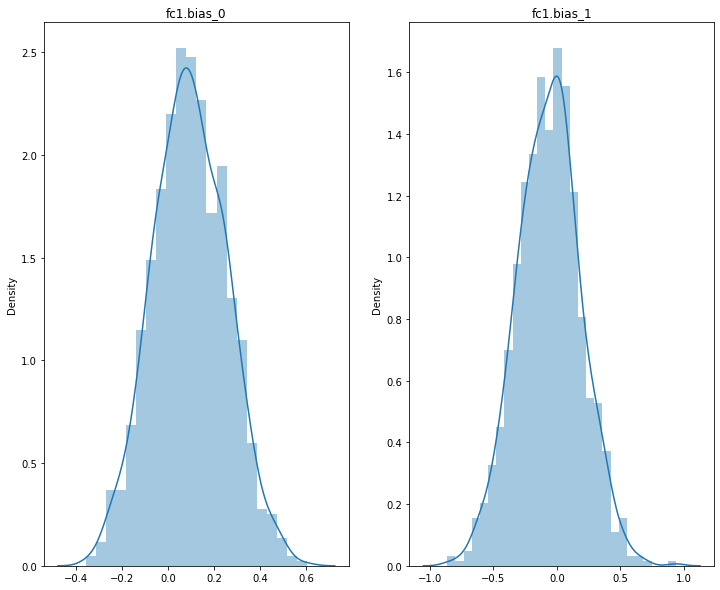

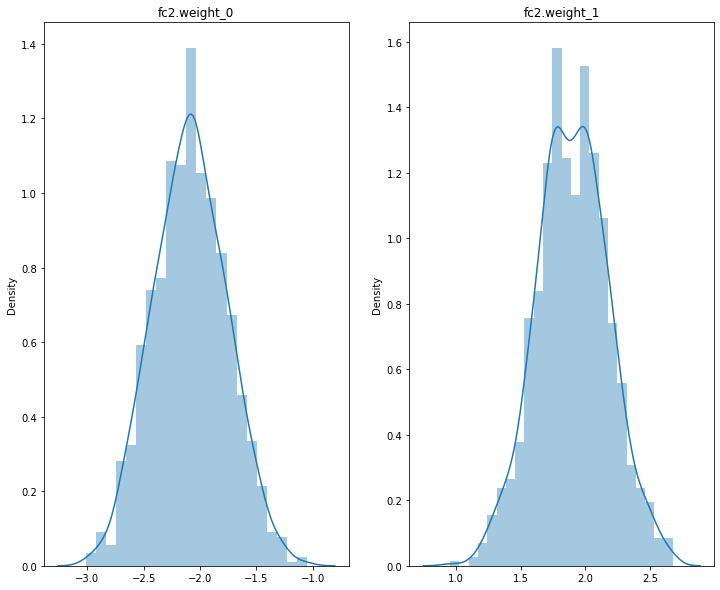

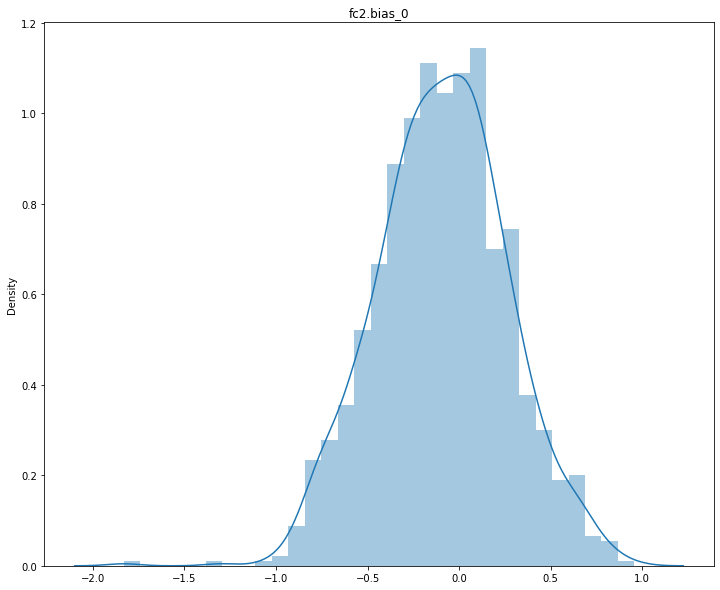

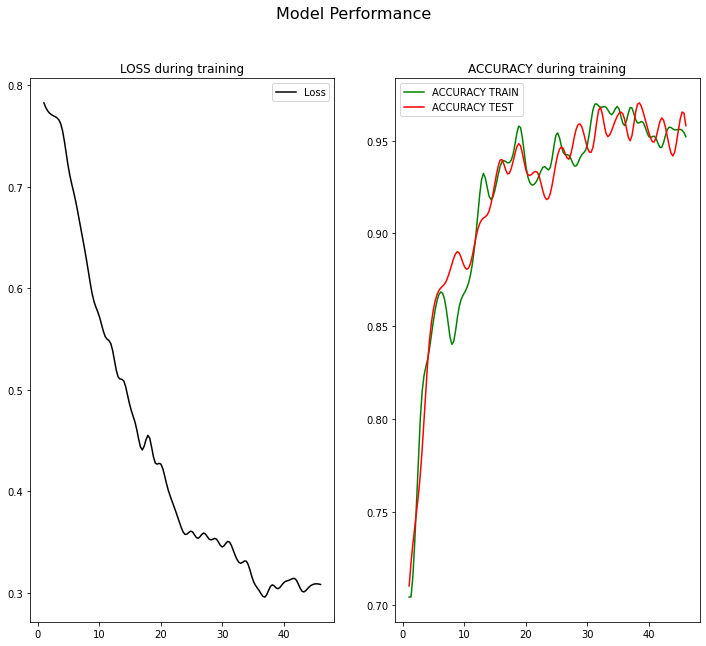

In [ ]:
neural_model_sanity_check = NNSanityCheck(in_features=2,
                             hidden_features=2,
                             out_features=1)

bayesian_model = BayesianNeuralNetwork(neural_model=neural_model_sanity_check, eval_type="logistic_regression")
bayesian_model.train(X_train_sanity_check, Y_train_sanity_check, X_test_sanity_check, Y_test_sanity_check,
                     guide="AutoDiagonalNormal",
                     lr=0.05,
                     no_epochs=50, 
                     batch_size="all", 
                     sample_from_distribution_for_evaluation=False,
                     plot_hist=True,
                     sanity_check=True, 
                     evaluate=True,
                     frequency=5
                     )

**Observations**: Overall, it seems like both methods achieve comparable results (around 98-100% accuracy on both train and test). The problem is the high time of training for the Bayesian network, which can become an important issue in practice (while manipulating large datasets).

### **Two Moons Dataset (Binary Classification)**

**Prepare the datasets**

In [ ]:
X_two_moons, Y_two_moons = make_moons(noise=0.2, random_state=0, n_samples=1000)
X_two_moons = torch.tensor(X_two_moons, dtype=torch.float)
Y_two_moons = torch.tensor(Y_two_moons, dtype=torch.float)

X_train_two_moons, X_test_two_moons, Y_train_two_moons, Y_test_two_moons = train_test_split(X_two_moons, Y_two_moons, test_size=0.2)

print(X_train_two_moons.shape, Y_train_two_moons.shape)
print(X_test_two_moons.shape, Y_test_two_moons.shape)

torch.Size([800, 2]) torch.Size([800])
torch.Size([200, 2]) torch.Size([200])


**NN network for Two Moons Dataset (binary classification)**

In [ ]:
class NNTwoMoons(nn.Module):
    def __init__(self, in_features, h1, h2, h3, out_features):
        super(NNTwoMoons, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, out_features)
        
    def forward(self, x):
        res = torch.relu(self.fc1(x))
        res = torch.relu(self.fc2(res))
        res = torch.relu(self.fc3(res))
        res = torch.tanh(self.fc4(res))
        res = torch.sigmoid(res)
        return torch.squeeze(res)

**Deep Learning Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 0.006352035328745842, ACCURACY_train: 0.8125, ACCURACY_test: 0.76
[Epoch = 5 -> LOSS_train: 0.005882009398192167, ACCURACY_train: 0.8525, ACCURACY_test: 0.785
[Epoch = 10 -> LOSS_train: 0.005661944858729839, ACCURACY_train: 0.8675, ACCURACY_test: 0.825
[Epoch = 15 -> LOSS_train: 0.005629762541502714, ACCURACY_train: 0.87875, ACCURACY_test: 0.86
[Epoch = 20 -> LOSS_train: 0.005610059481114149, ACCURACY_train: 0.88375, ACCURACY_test: 0.865
[Epoch = 25 -> LOSS_train: 0.005580080207437277, ACCURACY_train: 0.91375, ACCURACY_test: 0.88
[Epoch = 30 -> LOSS_train: 0.005535949021577835, ACCURACY_train: 0.9525, ACCURACY_test: 0.92
[Epoch = 35 -> LOSS_train: 0.005497416481375694, ACCURACY_train: 0.96625, ACCURACY_test: 0.945
[Epoch = 40 -> LOSS_train: 0.005480053368955851, ACCURACY_train: 0.965, ACCURACY_test: 0.955
[Epoch = 45 -> LOSS_train: 0.005472049582749605, ACCURACY_train: 0.96875, ACCURACY_test: 0.955
[Epoch = 50 -> LOSS_tr

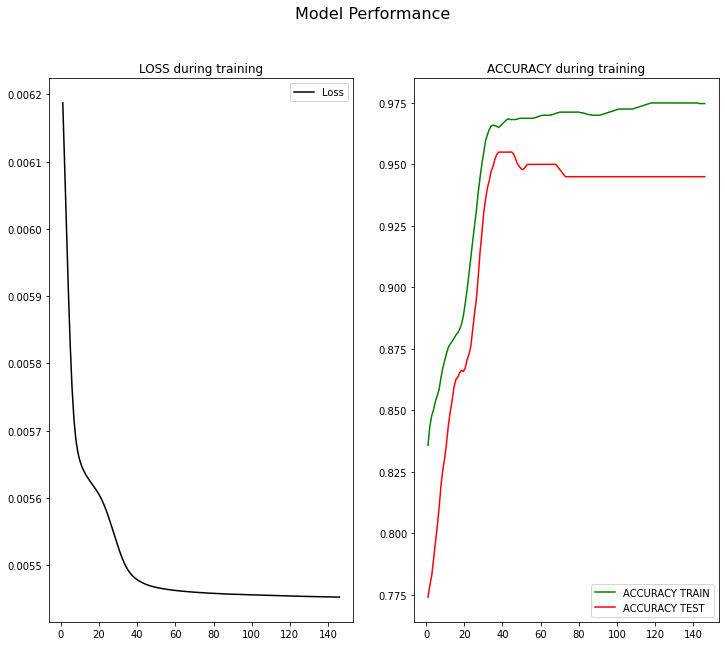

In [ ]:
neural_model_two_moons = NNTwoMoons(in_features=2,
                                    h1=32,
                                    h2=64,
                                    h3=32,
                                    out_features=1)

train_deep_learning(neural_model_two_moons, 
                    X_train_two_moons, Y_train_two_moons, X_test_two_moons, Y_test_two_moons,
                    eval_type="logistic_regression",
                    lr=0.001,
                    epochs=150,
                    batch_size=128,
                    frequency=5)

**Bayesian Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 10.744647505804897, ACCURACY_train: 0.76875, ACCURACY_test: 0.7 
[Epoch = 1 -> LOSS_train: 10.277172598317266, ACCURACY_train: 0.585, ACCURACY_test: 0.735 
[Epoch = 2 -> LOSS_train: 10.060449014976621, ACCURACY_train: 0.8425, ACCURACY_test: 0.81 
[Epoch = 3 -> LOSS_train: 9.609416128769517, ACCURACY_train: 0.85125, ACCURACY_test: 0.775 
[Epoch = 4 -> LOSS_train: 9.374258555099368, ACCURACY_train: 0.855, ACCURACY_test: 0.81 
[Epoch = 5 -> LOSS_train: 9.079658186882734, ACCURACY_train: 0.85625, ACCURACY_test: 0.815 
[Epoch = 6 -> LOSS_train: 8.897731112390757, ACCURACY_train: 0.8725, ACCURACY_test: 0.825 
[Epoch = 7 -> LOSS_train: 8.68223872512579, ACCURACY_train: 0.8675, ACCURACY_test: 0.79 
[Epoch = 8 -> LOSS_train: 8.37406684793532, ACCURACY_train: 0.8775, ACCURACY_test: 0.805 
[Epoch = 9 -> LOSS_train: 8.046213314831256, ACCURACY_train: 0.87875, ACCURACY_test: 0.78 
[Epoch = 10 -> LOSS_train: 7.826044889762998, ACCURAC

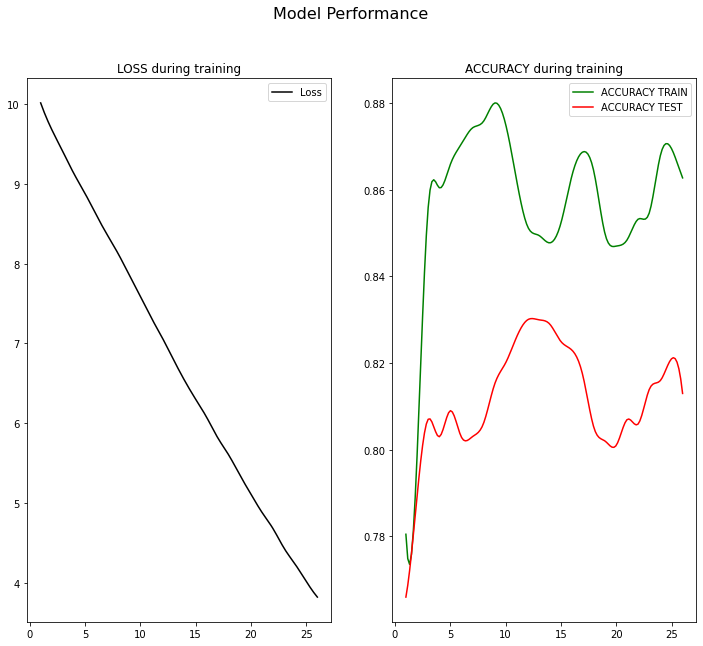

In [ ]:
neural_model_two_moons = NNTwoMoons(in_features=2,
                                    h1=32,
                                    h2=64,
                                    h3=32,
                                    out_features=1)

bayesian_model = BayesianNeuralNetwork(neural_model=neural_model_two_moons, eval_type="logistic_regression")
bayesian_model.train(X_train_two_moons, Y_train_two_moons, X_test_two_moons, Y_test_two_moons,
                     guide="AutoDiagonalNormal",
                     lr=0.05,
                     no_epochs=30, 
                     batch_size="all",  
                     sample_from_distribution_for_evaluation=False,
                     plot_hist=True, 
                     evaluate=True,
                     frequency=1
                     )

**Observation:** The Deep Learning approach gives better results overall, but it requires more epochs (150 vs 30). Even so, the gap is not that big (around 10% loss in accuracy), the results being still impresive (since the dataset is not a real, but an artificial designed one). The graphs seem to indicate that more epochs should increase the performance of the bayesian model, but the limited resources and the high training time imposed some limitation in this case.

### **Multi-class Classification**

In [ ]:
X_multiclass, Y_multiclass = make_classification(n_samples=5000,
                                                 n_features=25,
                                                 n_informative=10,
                                                 n_redundant=5,
                                                 n_classes=5)

X_multiclass = torch.tensor(X_multiclass, dtype=torch.float)
Y_multiclass = torch.tensor(Y_multiclass, dtype=torch.long)

X_train_multiclass, X_test_multiclass, Y_train_multiclass, Y_test_multiclass = train_test_split(X_multiclass, Y_multiclass, test_size=0.2)

print(X_train_multiclass.shape, Y_train_multiclass.shape)
print(X_test_multiclass.shape, Y_test_multiclass.shape)

torch.Size([4000, 25]) torch.Size([4000])
torch.Size([1000, 25]) torch.Size([1000])


**NN model for multiclass problem**

In [ ]:
class NNMulticlass(nn.Module):
    def __init__(self, in_features, h1, h2, h3, out_features):
        super(NNMulticlass, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, out_features)
        
    def forward(self, x):
        res = torch.relu(self.fc1(x))
        res = torch.relu(self.fc2(res))
        res = torch.relu(self.fc3(res))
        res = torch.relu(self.fc4(res))
        res = torch.softmax(res, dim=-1)

        return res

**Deep Learning Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 0.012827715836465359, ACCURACY_train: 0.35725, ACCURACY_test: 0.312
[Epoch = 5 -> LOSS_train: 0.010237308219075203, ACCURACY_train: 0.64175, ACCURACY_test: 0.605
[Epoch = 10 -> LOSS_train: 0.00977142434567213, ACCURACY_train: 0.6915, ACCURACY_test: 0.653
[Epoch = 15 -> LOSS_train: 0.009604939259588718, ACCURACY_train: 0.711, ACCURACY_test: 0.663
[Epoch = 20 -> LOSS_train: 0.009500888176262379, ACCURACY_train: 0.7205, ACCURACY_test: 0.662
[Epoch = 25 -> LOSS_train: 0.009428797289729118, ACCURACY_train: 0.727, ACCURACY_test: 0.673
[Epoch = 30 -> LOSS_train: 0.009372802451252937, ACCURACY_train: 0.72725, ACCURACY_test: 0.662
[Epoch = 35 -> LOSS_train: 0.009327935054898262, ACCURACY_train: 0.7305, ACCURACY_test: 0.67
[Epoch = 40 -> LOSS_train: 0.009289206005632877, ACCURACY_train: 0.72975, ACCURACY_test: 0.673
[Epoch = 45 -> LOSS_train: 0.009260307997465134, ACCURACY_train: 0.72875, ACCURACY_test: 0.674
[Epoch = 50 -> LOSS_t

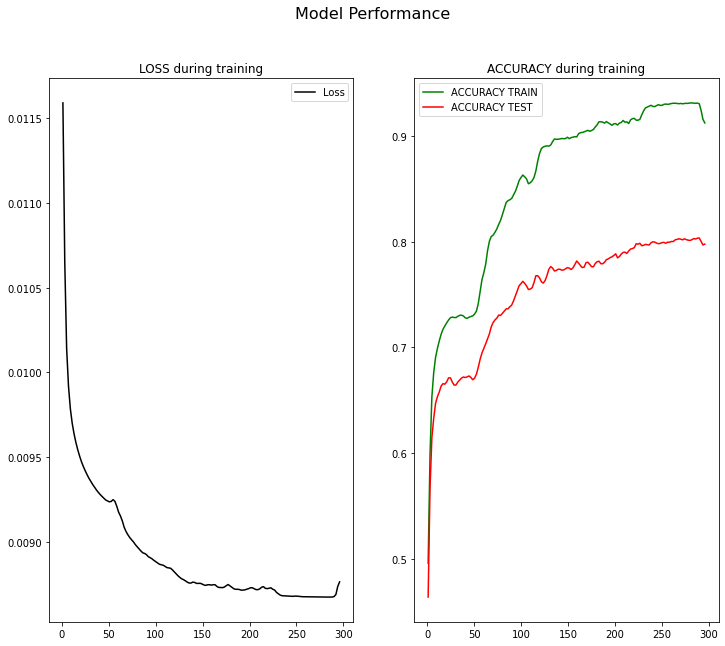

In [ ]:
neural_model_multiclass = NNMulticlass(in_features=25,
                                       h1=32,
                                       h2=64,
                                       h3=32,
                                       out_features=5)


train_deep_learning(neural_model_multiclass, 
                    X_train_multiclass, Y_train_multiclass, X_test_multiclass, Y_test_multiclass,
                    eval_type="classification",
                    lr=0.001,
                    epochs=300,
                    batch_size=128,
                    frequency=5)

**Bayesian Approach**

########## STARTED TRAINING ##########

[Epoch = 0 -> LOSS_train: 4.082849900722504, ACCURACY_train: 0.2035, ACCURACY_test: 0.223 
[Epoch = 1 -> LOSS_train: 4.040980489850044, ACCURACY_train: 0.311, ACCURACY_test: 0.31 
[Epoch = 2 -> LOSS_train: 3.9173802536726, ACCURACY_train: 0.33025, ACCURACY_test: 0.325 
[Epoch = 3 -> LOSS_train: 3.8130073158740996, ACCURACY_train: 0.3215, ACCURACY_test: 0.364 
[Epoch = 4 -> LOSS_train: 3.757606604576111, ACCURACY_train: 0.354, ACCURACY_test: 0.346 
[Epoch = 5 -> LOSS_train: 3.694390314936638, ACCURACY_train: 0.3465, ACCURACY_test: 0.321 
[Epoch = 6 -> LOSS_train: 3.614209633708, ACCURACY_train: 0.39625, ACCURACY_test: 0.419 
[Epoch = 7 -> LOSS_train: 3.6122993783950808, ACCURACY_train: 0.37575, ACCURACY_test: 0.389 
[Epoch = 8 -> LOSS_train: 3.467887854218483, ACCURACY_train: 0.4495, ACCURACY_test: 0.398 
[Epoch = 9 -> LOSS_train: 3.4651805897951125, ACCURACY_train: 0.384, ACCURACY_test: 0.342 
[Epoch = 10 -> LOSS_train: 3.3318528261184692, ACCURA

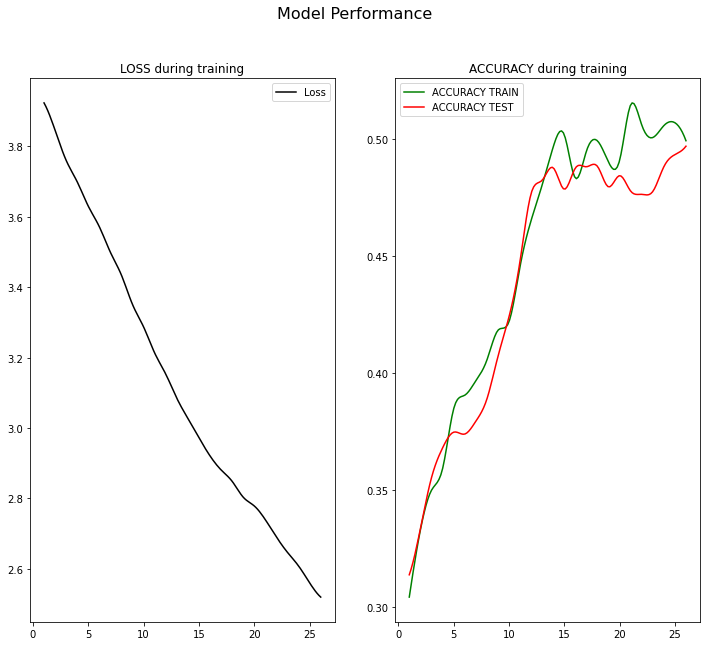

In [ ]:
neural_model_multiclass = NNMulticlass(in_features=25,
                                       h1=32,
                                       h2=64,
                                       h3=32,
                                       out_features=5)

bayesian_model = BayesianNeuralNetwork(neural_model=neural_model_multiclass, eval_type="classification")
bayesian_model.train(X_train_multiclass, Y_train_multiclass, X_test_multiclass, Y_test_multiclass,
                     guide="AutoDiagonalNormal",
                     lr=0.05,
                     no_epochs=30, 
                     batch_size="all", 
                     sample_from_distribution_for_evaluation=False,
                     plot_hist=True, 
                     evaluate=True,
                     frequency=1
                     )

**Observation:** Again, the Deep Learning model is ahead of the Bayesian Network when compared to final performance. Even so, it seems to enter an overfitting regim, so this architecture is not probably the best one for the task at hand even for the DL approach (which is difficult enough, with 5 classes and a lot of redundant features which are very difficult to spot). A better choosing of the learning_rate (even though i tried various lr between 0.001 ... 0.1]), another automatic guide and more epochs would probably reduce the gap, but because of the high training time, I couldnt do a proper hyperparameter-tuning. 

**Final Comments:**
  - Bayesian Network achieve high performance when compared directly to Deep Learning model.
  -  As a big issue we should consider the high training time, expecially on larger datasets (for instance an epoch could take some order of magnitude more than what it would take to a neural model)

**Bonus/Extra:**
  - I implemented a *generic bayesian network* that automatically converts a Deep Learning model received as paramtere. It can be then used to start the training and plot the relevant information (distributions for each parameters, histograms, etc) very easily (most of the parameters needed are either passed to train() method or are inferred automatically).
  - There are various parameters that can be easily chosen to get high performance such as: different type of AutoGuides (AutoDiagonalNormal, AutoLowRankMultivariateNormal + an own guide implementation), different training hyperparameters (lr, epoch, batch_size) and more. 
  - The Bayesian framework created work for Regression problems as well, by using a Normal around the predictions(it infers the necessary func_score and criterion based on the task at hand. Supported tasks so far: regression, logistic_regression, multiclass_regression).
  - For the testing purpose, I implemented a majority algorithm to fairly predict the results (for classification a majority vote is applied (after convertind the probabilites to class indexes), while for regression a mean method is used). When predicti
